#### Import packages
ref: https://github.com/adashofdata/muffin-cupcake/blob/master/muffin_vs_cupcake_demo.ipynb

In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.2)
from sklearn import svm
from sklearn.model_selection import train_test_split

#### Import data

In [466]:
df = pd.read_csv('dough_comp.csv')
print(df.head(3))
print(df.tail(3))

   Flour   Water  Yeast  Salt   Type                 Source
0  480.0  340.50    7.0  12.0  pizza  foodnetwork-bobbyflay
1  276.9  170.25    7.0   4.5  pizza           sugarspunrun
2  420.0  301.91    7.0   4.5  pizza  sallysbakingaddiction
    Flour  Water  Yeast  Salt   Type              Source
37  360.0  340.5   6.00   9.0  bread     joyfoodsunshine
38  400.0  300.0   1.00   8.0  bread          epicurious
39  450.0  340.5   6.75  13.5  bread  olgasflavorfactory


#### Prepare Data

In [467]:
# Drop unecessary column
recipes = df.drop('Source', axis=1)

# Sum of ingredients by weight
recipes['Sum'] = recipes['Flour'] + recipes['Water'] + recipes['Yeast'] + recipes['Salt']
recipes = recipes.reindex(columns=['Flour','Water','Yeast','Salt','Sum','Type'])
recipes.head(3)

,Flour,Water,Yeast,Salt,Sum,Type
0,480.0,340.50,7.0,12.0,839.50,pizza
1,276.9,170.25,7.0,4.5,458.65,pizza
2,420.0,301.91,7.0,4.5,733.41,pizza


In [468]:
# Convert quantity of ingredients based on two options
# 1: regular percentage (p), 2: baker's percentage (bp)
recipes_p = recipes.copy()
recipes_bp = recipes.copy()

for i in range(4):
    recipes_p.iloc[:,i] = round(recipes_p.iloc[:,i] / recipes['Sum'] * 100, 2)
    recipes_bp.iloc[:,i] = round(recipes_bp.iloc[:,i] / recipes['Flour'] * 100, 2)

# Drop unecessary calculation columns
# For baker's percentage, flour is always 100%
recipes_p.drop('Sum', axis=1, inplace=True)
recipes_bp.drop(['Flour','Sum'], axis=1, inplace=True)

print(recipes_p.head(3))
print(recipes_bp.head(3))

   Flour  Water  Yeast  Salt   Type
0  57.18  40.56   0.83  1.43  pizza
1  60.37  37.12   1.53  0.98  pizza
2  57.27  41.17   0.95  0.61  pizza
   Water  Yeast  Salt   Type
0  70.94   1.46  2.50  pizza
1  61.48   2.53  1.63  pizza
2  71.88   1.67  1.07  pizza


#### Data Observation

In [469]:
df_observe = pd.DataFrame([recipes_p[recipes_p['Type'] == 'pizza'].min()])
df_observe = df_observe.append([recipes_p[recipes_p['Type'] == 'pizza'].max()])
df_observe = df_observe.append([recipes_p[recipes_p['Type'] == 'bread'].min()])
df_observe = df_observe.append([recipes_p[recipes_p['Type'] == 'bread'].max()])
df_observe.index = ['min pizza', 'max pizza', 'min bread', 'max bread']
df_observe.drop('Type', axis=1, inplace=True)
df_observe

,Flour,Water,Yeast,Salt
min pizza,54.16,34.71,0.09,0.61
max pizza,63.64,43.91,1.66,1.58
min bread,50.31,40.58,0.11,0.43
max bread,57.97,48.35,0.87,1.68


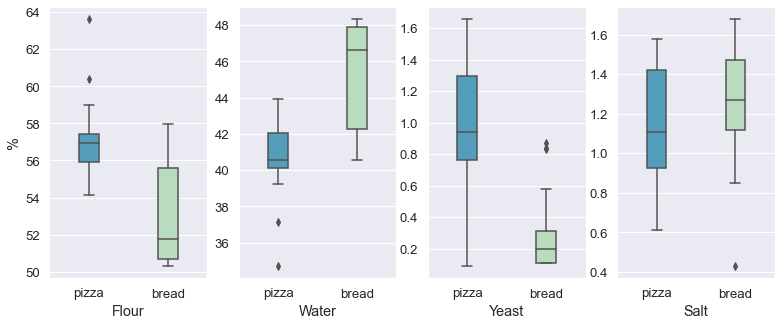

In [360]:
# Boxplot comparing ingredient percentages
fig, axs = plt.subplots(ncols=4, sharex=True, figsize=(13,5))
fig.ylabel ='%'

sns.boxplot(x="Type", y="Flour", data=recipes_p, palette='GnBu_r', width=0.25, 
            ax=axs[0]).set(xlabel='Flour', ylabel='%', xticklabels=[])
sns.boxplot(x="Type", y="Water", data=recipes_p, palette='GnBu_r', width=0.25, 
            ax=axs[1]).set(xlabel='Water', ylabel=None, xticklabels=[])
sns.boxplot(x="Type", y="Yeast", data=recipes_p, palette='GnBu_r', width=0.25, 
            ax=axs[2]).set(xlabel='Yeast', ylabel=None)
sns.boxplot(x="Type", y="Salt", data=recipes_p, palette='GnBu_r', width=0.25, 
            ax=axs[3]).set(xlabel='Salt', ylabel=None)
# axs[0].set_xticklabels([None, None])
plt.show()

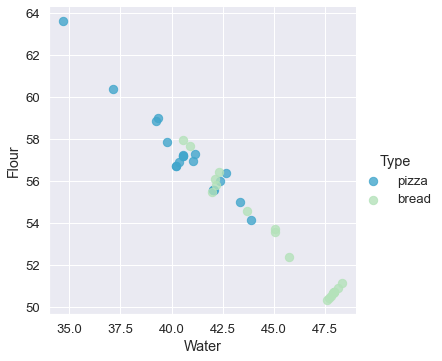

In [470]:
# Visualize the most stark difference: flour and water ratio
sns.lmplot(x='Water', y='Flour', data=recipes_p, hue='Type',
           palette='GnBu_r', fit_reg=False, scatter_kws={"s": 70});

#### SVM on Flour and Water

In [471]:
# Specify inputs for the model
ingredients = recipes_p[['Flour','Water']].to_numpy()
type_label = np.where(recipes_p['Type']=='bread', 0, 1)

type_label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [472]:
# Fit the SVM model
model = svm.SVC(kernel='linear')
model.fit(ingredients, type_label)

SVC(kernel='linear')

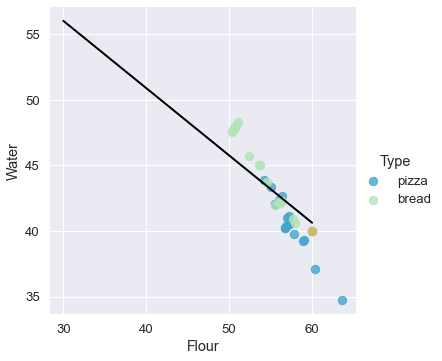

In [473]:
# Get the separating hyperplane
w = model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(30, 60)
yy = a * xx - (model.intercept_[0]) / w[1]

# Plot the hyperplane
sns.lmplot(x='Flour', y='Water', data=recipes_p, hue='Type', palette='GnBu_r', fit_reg=False, scatter_kws={"s": 70})
plt.plot(xx, yy, linewidth=2, color='black')
plt.plot(60, 40, 'yo', markersize='9')
plt.show()

In [474]:
# Create a function to guess when a recipe is for bread dough or pizza dough
def bread_or_pizza(flour, water):
    if(model.predict([[flour, water]]))==0:
        print('You\'re looking at a bread dough recipe!')
    else:
        print('You\'re looking at a pizza dough recipe!')

In [475]:
# Predict if 60 parts flour and 40 parts water
bread_or_pizza(60, 40)

You're looking at a pizza dough recipe!


#### SVM on all ingredients

In [476]:
train, test = train_test_split(recipes_p, test_size=0.33, random_state=42)

train_x = train.loc[:,'Flour':'Salt']
train_y = train['Type']
test_x = test.loc[:,'Flour':'Salt']
test_y = test['Type']

print(len(train_x), len(test_x))

26 14


In [477]:
# Fit the SVM model
model = svm.SVC(kernel='linear')
model.fit(train_x, train_y)

# Testing a sample
print(model.predict([test_x.iloc[1]]))
print(test_y.iloc[1])

['pizza']
pizza


#### Evaluation

In [478]:
from sklearn.metrics import f1_score

print(model.score(test_x, test_y))
print(f1_score(test_y, model.predict(test_x), average=None, labels=['bread', 'pizza']))

0.7142857142857143
[0.71428571 0.71428571]


In [479]:
# Testing for improvement with a GridSearch
from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

model = GridSearchCV(svm.SVC(), parameters, cv=5)
model.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')})

In [480]:
print(model.score(test_x, test_y))
print(f1_score(test_y, model.predict(test_x), average=None, labels=['bread', 'pizza']))

0.7142857142857143
[0.71428571 0.71428571]
